In [5]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
import pickle
import glob
from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

In [6]:
class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))+c

def Gauss_2d_LC_func_gen(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt_gen(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V


In [8]:
# np.array(keys1021)[[1,2,10]]

In [9]:
# OCTOBER 21 FLIGHT READ IN

keys1021 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/20211021T*')]
keys1021.sort()

dict1021 = {}
for key in np.array(keys1021)[[1,2,10]]:
    with open('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
        f.close()
    dict1021[key] = dict_to_class_cut(loaded_dict)
    print(key)


20211021T144917Z
20211021T151703Z
20211021T214040Z


In [10]:
freq = 900
X,Y = np.meshgrid(np.linspace(-50,50,1000), np.linspace(-50,50,1000))

i = keys1021[1]
inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
y = dict1021[i].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,1], axis = 1)))
Z1 = griddata((x,y), z, (X,Y))

i = keys1021[2]
inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
y = dict1021[i].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,1], axis = 1)))
Z2 = griddata((x,y), z, (X,Y))

i = keys1021[10]
inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
y = dict1021[i].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,1], axis = 1)))
Z10 = griddata((x,y), z, (X,Y))

In [11]:
scatter(X,Y,c = np.abs(10*np.log10(Z3)-10*np.log10(Z4)), vmin = 0, vmax = 1, cmap='gnuplot2')
colorbar()

NameError: name 'Z3' is not defined

In [ ]:
plot(Z3[:,500])
plot(Z4[:,500])
show()

plot(Z3[500,:])
plot(Z4[500,:])
show()

In [12]:
## AUGUST 26 FLIGHT READ IN

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

for key in ['20210826T170324Z', '20210826T182915Z','20210826T195014Z']:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)


20210826T170324Z
20210826T182915Z
20210826T195014Z


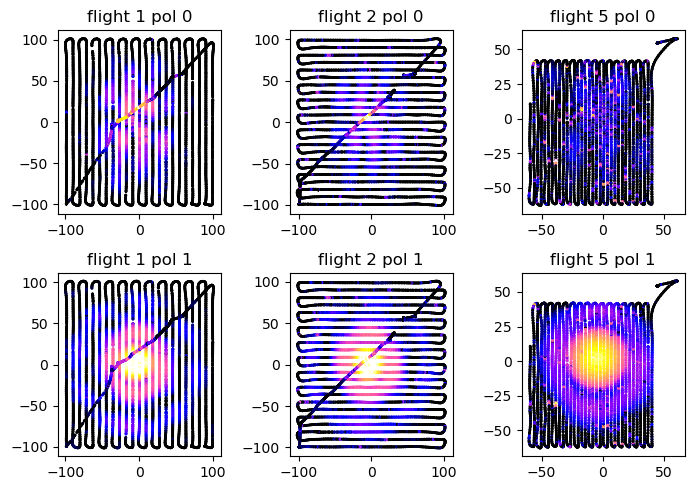

In [13]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    try: 
        dotsize=1
        freq = 900
        inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
        indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
        x = dict826[i].drone_xyz_LC_interp[indsuse,0]
        y = dict826[i].drone_xyz_LC_interp[indsuse,1]

        ax=fig.add_subplot(2,6,counter)
        z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
        ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
        ax.set_title('flight '+str(k) + ' pol 0')

        ax=fig.add_subplot(2,6,counter+6)
        z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
        ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
        ax.set_title('flight '+str(k) + ' pol 1')
        counter +=1

    except: pass
# suptitle('August Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

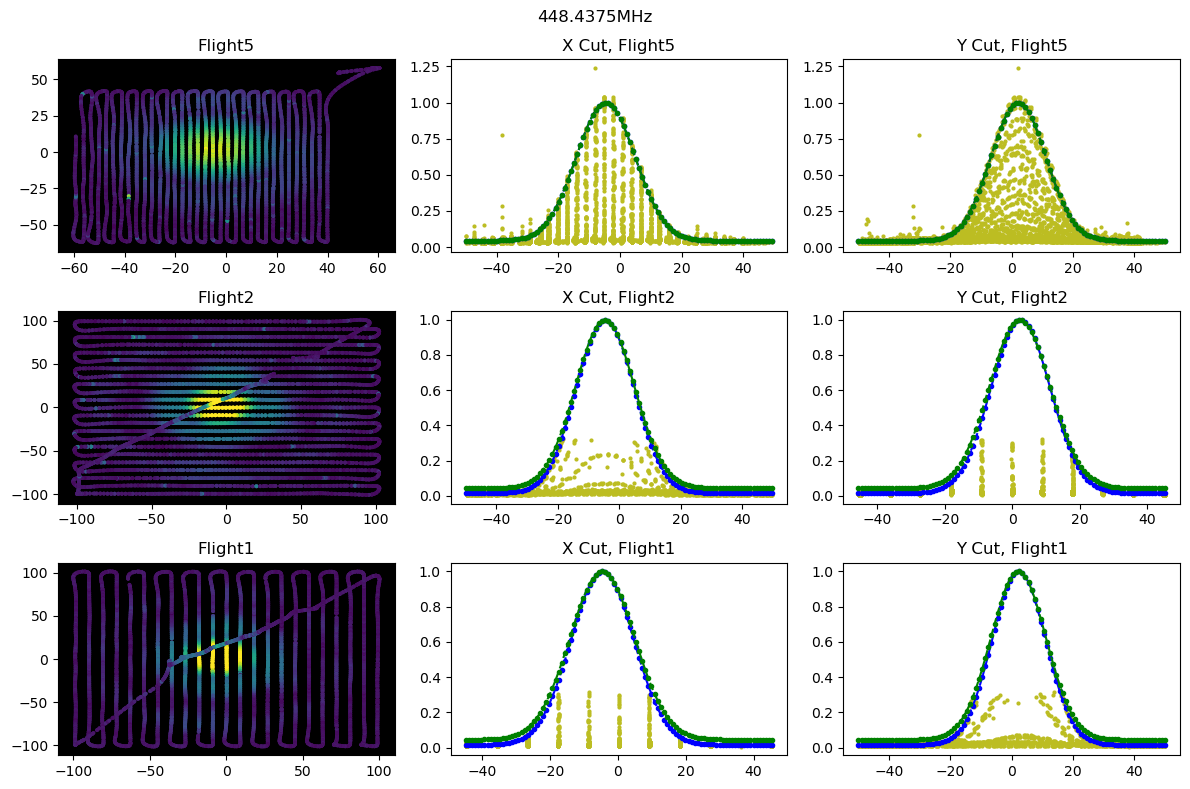

In [14]:
for find in [900]:
    fig=figure(figsize=(12,8))
    for counter, num in enumerate([5,2,1]):
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 5:
            Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


        ax=fig.add_subplot(3,3,3*(counter)+1)
        ax.set_title('Flight' + str(num))
        ax.set_facecolor('k')
        ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
                   c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)


        ax=fig.add_subplot(3,3,3*(counter)+2)

        ## PLOT 1
    #     ax=ax1
        ax.set_title('X Cut, Flight' + str(num)) 
        zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt5[3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')

        ax=fig.add_subplot(3,3,3*(counter)+3)

        ## PLOT 2
    #     ax=ax2
        ax.set_title('Y Cut, Flight' + str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,Gpopt5[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')
    suptitle(str(tempconcat.freq[find])+'MHz', fontsize = 12)
    tight_layout()
    show()



[ 8.49683136e-08 -6.29452717e+00  8.05974792e+00  1.62140349e+00
  9.20141970e+00 -2.46771331e+00  4.86631013e-09]
[ 7.93781013e-08 -6.26547516e+00  8.27636958e+00  1.55465486e+00
  9.76411491e+00 -5.59341630e+00  4.82590058e-09]
[ 2.38522403e-08 -6.48283445e+00  7.93322205e+00  1.46207189e+00
  9.08032668e+00 -8.66538142e+00  5.21503973e-09]


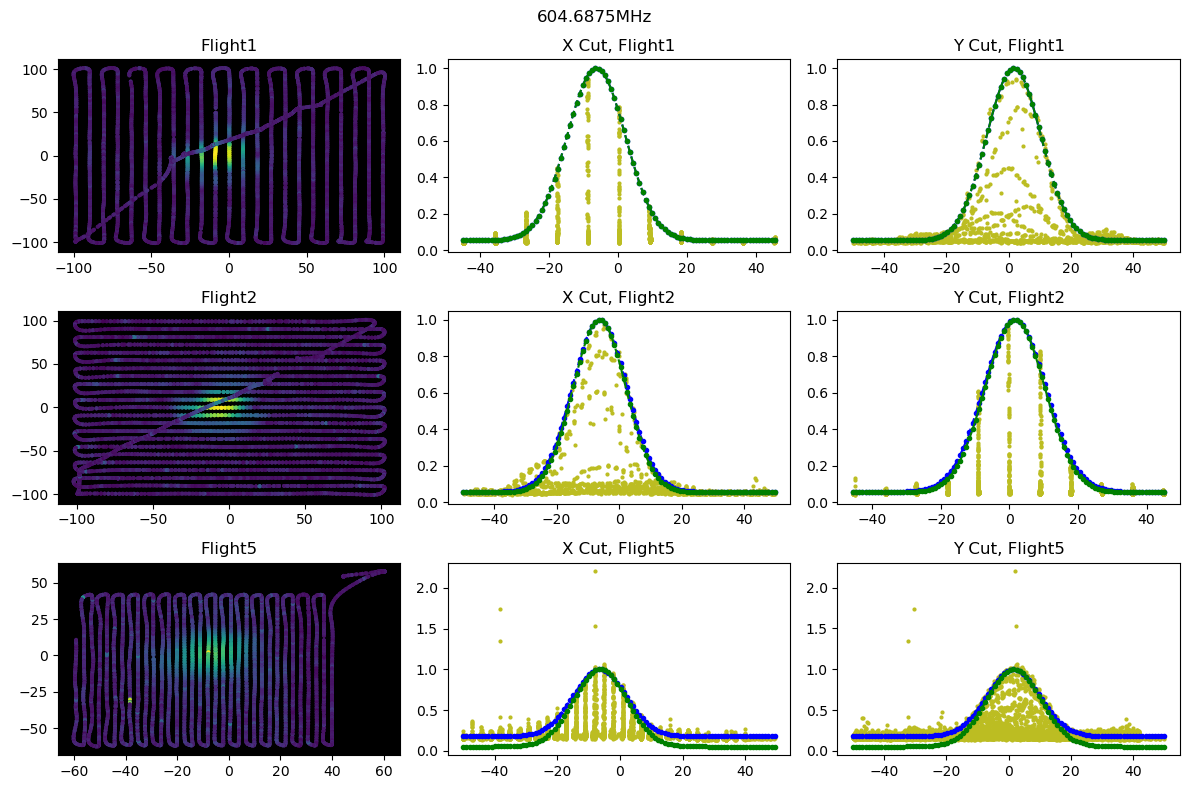

In [15]:
for find in [500]:
    fig=figure(figsize=(12,8))
    for counter, num in enumerate([1,2,5]):
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 1:
            Gpopt1=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


        ax=fig.add_subplot(3,3,3*(counter)+1)
        ax.set_title('Flight' + str(num))
        ax.set_facecolor('k')
        ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
                   c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)


        ax=fig.add_subplot(3,3,3*(counter)+2)

        ## PLOT 1
    #     ax=ax1
        ax.set_title('X Cut, Flight' + str(num)) 
        zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt1,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt1[3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')

        ax=fig.add_subplot(3,3,3*(counter)+3)

        ## PLOT 2
    #     ax=ax2
        ax.set_title('Y Cut, Flight' + str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt1,Gpopt1[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
        ax.semilogy
        print(Gpopt)
    #     ax.legend(loc = 'upper right')
    suptitle(str(tempconcat.freq[find])+'MHz', fontsize = 12)
    tight_layout()
    show()



In [16]:
fitparams = {}
for find in np.arange(100,1000,10):
    fitparams[find] = {}
    for num in [1,2,5][::-1]:
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        fitparams[find][num] = Gpopt

In [17]:
dict826[keys826[5]].n_dishes
x,y = np.meshgrid(np.linspace(-100,100,100), np.linspace(-100,100,100))

num = 5 
fits_all_norm = {}
for num in [1]:
    print(num)
    fits = np.zeros((90, dict826[keys826[num]].n_dishes, 7))
    for i, find in enumerate(np.arange(100,1000,10)):
        for j, pol in enumerate(np.arange(1,16,2)):
            try:
                tempconcat=dict826[keys826[num]]
                tacut=tempconcat.t_index[tempconcat.V[:,find,pol]<0.999*(np.nanmax(tempconcat.V[:,find,pol]))]
                txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
                tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
                tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
                ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
                inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
                ## data points for fit:
                mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
                mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
                mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
                mbV=tempconcat.V[ttcut,find,pol]
                mbV=np.mean(np.abs(tempconcat.V_bgsub[ttcut,find:find+10,pol]), axis = 1)                
                mb_input_data=np.array([mbx,mby,mbV])
                ## shared params:
                amp0=np.nanmax(mbV)
                bg0=np.nanmin(mbV)
                x00=tempconcat.dish_coords[int(pol/2),0]
                y00=tempconcat.dish_coords[int(pol/2),1]
                ## airy params:
                rad0=25.0
                ## 2dgauss params:
                xsig0=6.0
                ysig0=6.0
                theta0=0.0
                pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
                z = Gauss_2d_LC_func_gen(Gpopt,x,y)
                z = z/z.max()
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=Gpopt,args=[x.ravel(),y.ravel(),z.ravel()]).x            
                for k, param in enumerate(Gpopt):
                    fits[i,j,k] = param
            except: pass
    fits_all_norm[num] = fits

1


In [18]:
dict826[keys826[5]].n_dishes
x,y = np.meshgrid(np.linspace(-100,100,100), np.linspace(-100,100,100))

num = 5 
fits_all_norm = {}
for num in [1,2,5]:
    print(num)
    fits = np.zeros((90, dict826[keys826[num]].n_dishes, 7))
    for i, find in enumerate(np.arange(100,1000,10)):
        for j, pol in enumerate(np.arange(1,dict826[keys826[num]].n_dishes*2,2)):
            try:
                tempconcat=dict826[keys826[num]]
                tacut=tempconcat.t_index[tempconcat.V[:,find,pol]<0.999*(np.nanmax(tempconcat.V[:,find,pol]))]
                txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
                tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
                tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
                ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
                inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
                ## data points for fit:
                mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
                mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
                mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
                mbV=tempconcat.V[ttcut,find,pol]
                mbV=np.mean(np.abs(tempconcat.V[ttcut,find:find+10,pol]), axis = 1) 
    #             mbV=np.mean(np.abs(tempconcat.V_bgsub[ttcut,find:find+10,pol]), axis = 1)                
                mb_input_data=np.array([mbx,mby,mbV])
                ## shared params:
                amp0=np.nanmax(mbV)
                bg0=np.nanmin(mbV)
                x00=tempconcat.dish_coords[int(pol/2),0]
                y00=tempconcat.dish_coords[int(pol/2),1]
                ## airy params:
                rad0=25.0
                ## 2dgauss params:
                xsig0=6.0
                ysig0=6.0
                theta0=0.0
                pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
                z = Gauss_2d_LC_func_gen(Gpopt,x,y)
                z = z/z.max()
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=Gpopt,args=[x.ravel(),y.ravel(),z.ravel()]).x   
                for k, param in enumerate(Gpopt):
                    fits[i,j,k] = param
            except: pass
    fits_all_norm[num] = fits

1
2


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


5


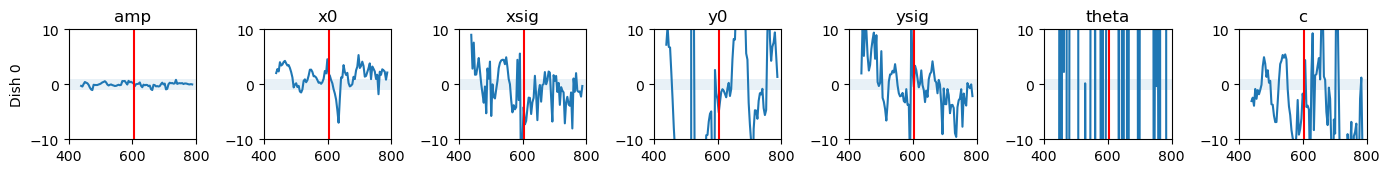

In [19]:
param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,12))

for j, dishnum in enumerate([0]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(8,7,j*7+k+1)
        try:
            ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
                    100*(fits_all_norm[1][:,dishnum,k]-fits_all_norm[2][:,dishnum,k])/fits_all_norm[1][:,dishnum,k], label = i)
        except: pass
        ax.axvline(tempconcat.freq[500], color = 'red')
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        if k == 0: ax.set_ylabel('Dish '+str(dishnum))
#         ax.set_xlabel('frequency')
        ax.set_xlim(400,800)
        ax.set_ylim(-10,10)
        ax.axhspan(-1,1,alpha = 0.1)
#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()


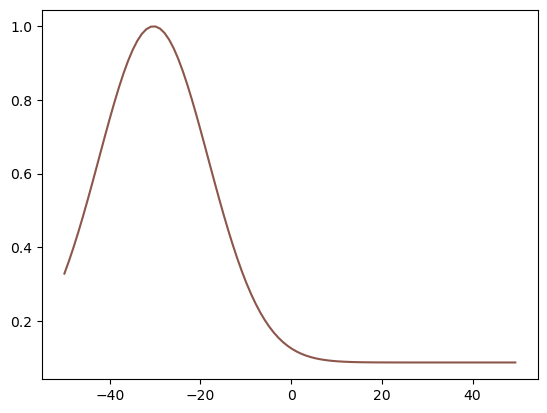

In [20]:
zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),fits_all_norm[1][5,0,3]*np.ones(100))
plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'C'+str(num),label='flight ' +str(num))
# fits_all_norm[1][5,0,3]

In [21]:
fig=figure(figsize=(12,8))

counter = 1
testargs = list(np.linspace(5,85,16, dtype = int))
for find in np.array(list(fitparams.keys()))[testargs]:    
    print(find)

150
200
250
310
360
410
470
520
570
630
680
730
790
840
890
950


<Figure size 1200x800 with 0 Axes>

In [22]:
list(np.linspace(5,85,16, dtype = int))
testargs = list(np.linspace(5,85,16, dtype = int))
testargs

[5, 10, 15, 21, 26, 31, 37, 42, 47, 53, 58, 63, 69, 74, 79, 85]

In [23]:
np.array(list(fitparams.keys()))[testargs]



array([150, 200, 250, 310, 360, 410, 470, 520, 570, 630, 680, 730, 790,
       840, 890, 950])

In [24]:
fits_all_norm[1][1,0,1]
fits_all_norm[1][1,0,1]

-10.376142285235213

In [25]:
np.linspace(10,1000,16, dtype = int)

array([  10,   76,  142,  208,  274,  340,  406,  472,  538,  604,  670,
        736,  802,  868,  934, 1000])

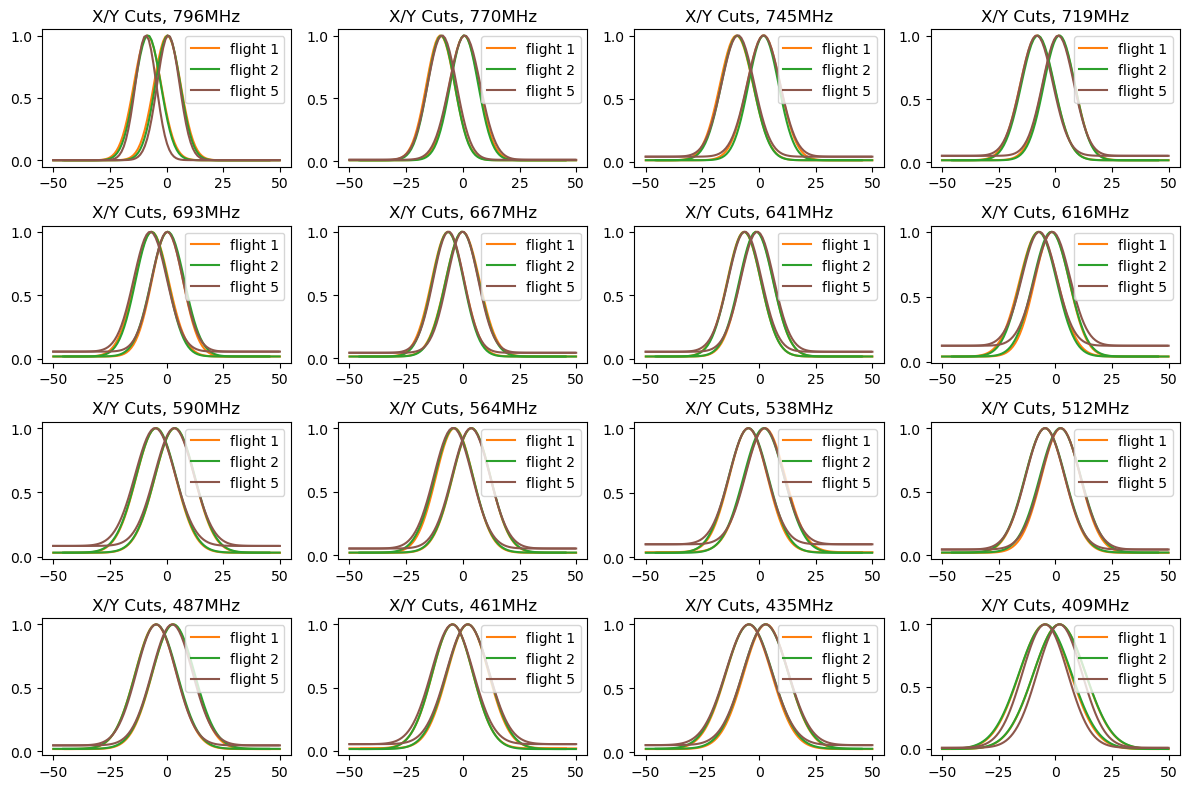

In [26]:
fig=figure(figsize=(12,8))

counter = 1
for find in np.linspace(10,1000,16, dtype = int):    
    ax=fig.add_subplot(4,4,counter)
    for num in [1,2,5]:
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        
        ax.set_title('X/Y Cuts, ' + str(round(tempconcat.freq[find]))+'MHz') 
        zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'C'+str(num),label='flight ' +str(num))
        ax.legend()
        
        
        
        
        
#         ax.set_title('Y Cut, Flight' + str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'C'+str(num))
#         ax.semilogy()

    counter +=1

tight_layout()
show()



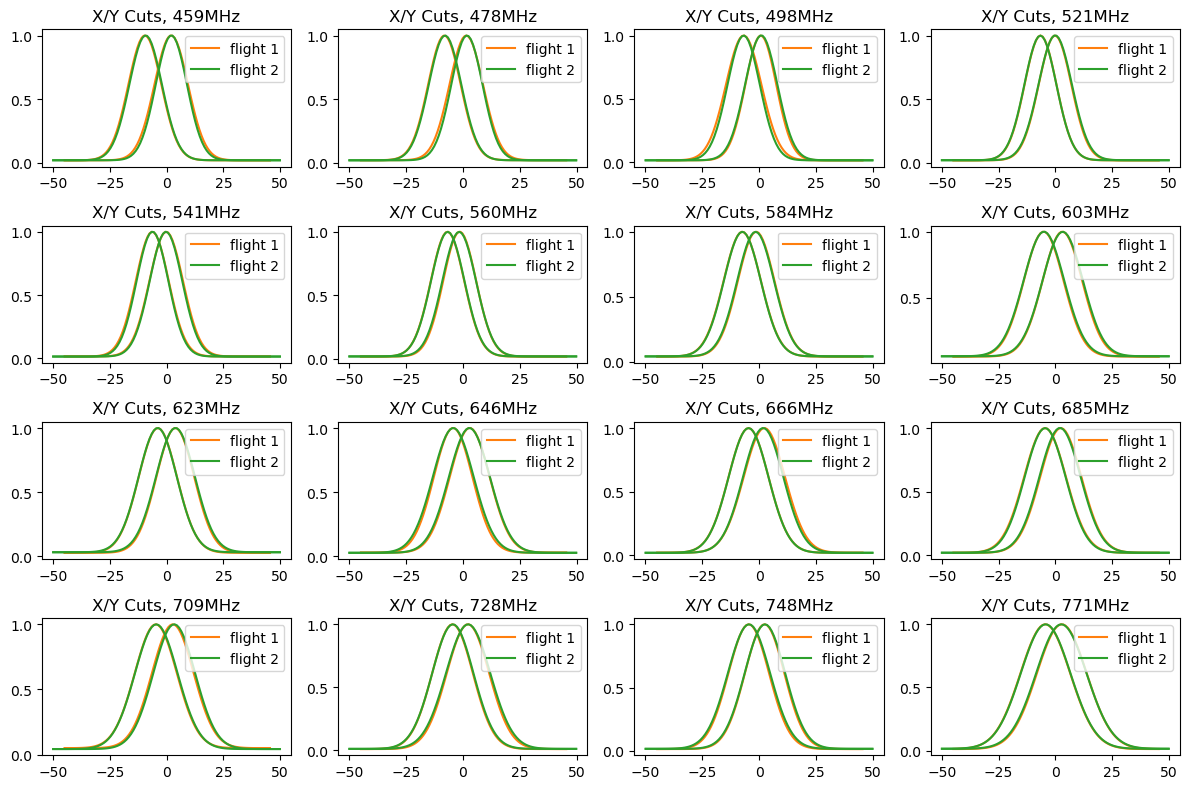

In [27]:
#checking whether plots generated from fit params look ok

fig=figure(figsize=(12,8))

counter = 1
testargs = list(np.linspace(5,85,16, dtype = int))
for find in testargs:    
    ax=fig.add_subplot(4,4,counter)
    for num in [1,2]:
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        ax.set_title('X/Y Cuts, ' + str(round(np.linspace(400,800,1024)[np.array(list(fitparams.keys()))[find]]))+'MHz') 
#         zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        zplot = Gauss_2d_LC_func_gen(fits_all_norm[num][find,0,:],np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),fits_all_norm[num][find,0,3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'C'+str(num),label='flight ' +str(num))
        ax.legend()
        
        
        zplot = Gauss_2d_LC_func_gen(fits_all_norm[num][find,0,:],fits_all_norm[num][find,0,1]*np.ones(100),np.linspace(np.nanmin(mbx),np.nanmax(mbx),100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'C'+str(num))
        
        
#         ax.set_title('Y Cut, Flight' + str(num))
#         zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
#         zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),fits_all_norm[num][5,0,1]*np.ones(100))
#         ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'C'+str(num))
#         ax.semilogy()

    counter +=1

tight_layout()
show()



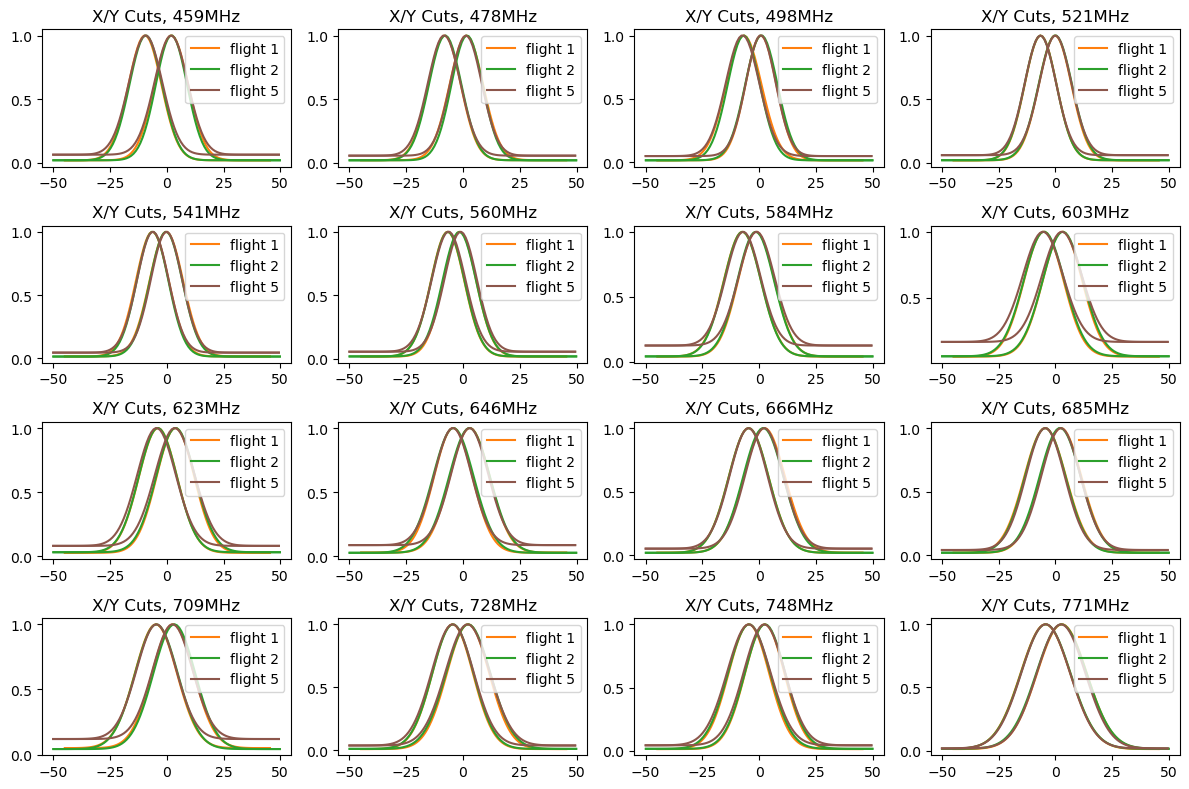

In [28]:
#checking whether plots generated from fit params look ok

fig=figure(figsize=(12,8))

counter = 1
testargs = list(np.linspace(5,85,16, dtype = int))
for find in testargs:    
    ax=fig.add_subplot(4,4,counter)
    for num in [1,2,5]:
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        ax.set_title('X/Y Cuts, ' + str(round(np.linspace(400,800,1024)[np.array(list(fitparams.keys()))[find]]))+'MHz') 
#         zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        zplot = Gauss_2d_LC_func_gen(fits_all_norm[num][find,0,:],np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),fits_all_norm[num][find,0,3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'C'+str(num),label='flight ' +str(num))
        ax.legend()
        
        
        zplot = Gauss_2d_LC_func_gen(fits_all_norm[num][find,0,:],fits_all_norm[num][find,0,1]*np.ones(100),np.linspace(np.nanmin(mbx),np.nanmax(mbx),100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'C'+str(num))
        
        
#         ax.set_title('Y Cut, Flight' + str(num))
#         zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
#         zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),fits_all_norm[num][5,0,1]*np.ones(100))
#         ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'C'+str(num))
#         ax.semilogy()

    counter +=1

tight_layout()
show()



In [29]:
#I guess I should understand how 

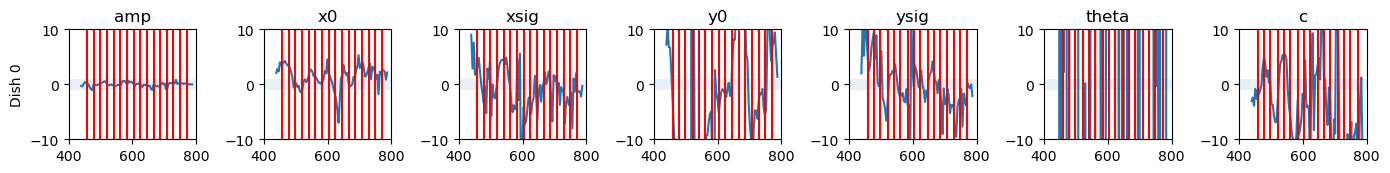

In [30]:
#see whether any big discrepancies correspond to freqs plotted above

param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,12))

for j, dishnum in enumerate([0]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(8,7,j*7+k+1)
        try:
            ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
                    100*(fits_all_norm[1][:,dishnum,k]-fits_all_norm[2][:,dishnum,k])/fits_all_norm[1][:,dishnum,k], label = i)
        except: pass
#         ax.axvline(tempconcat.freq[500], color = 'red')
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        if k == 0: ax.set_ylabel('Dish '+str(dishnum))
#         ax.set_xlabel('frequency')
        ax.set_xlim(400,800)
        ax.set_ylim(-10,10)
        ax.axhspan(-1,1,alpha = 0.1)
        
        
        for f in np.linspace(400,800,1024)[list(np.array(list(fitparams.keys()))[testargs])]:    
            ax.axvline(f, color = 'r')

#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()


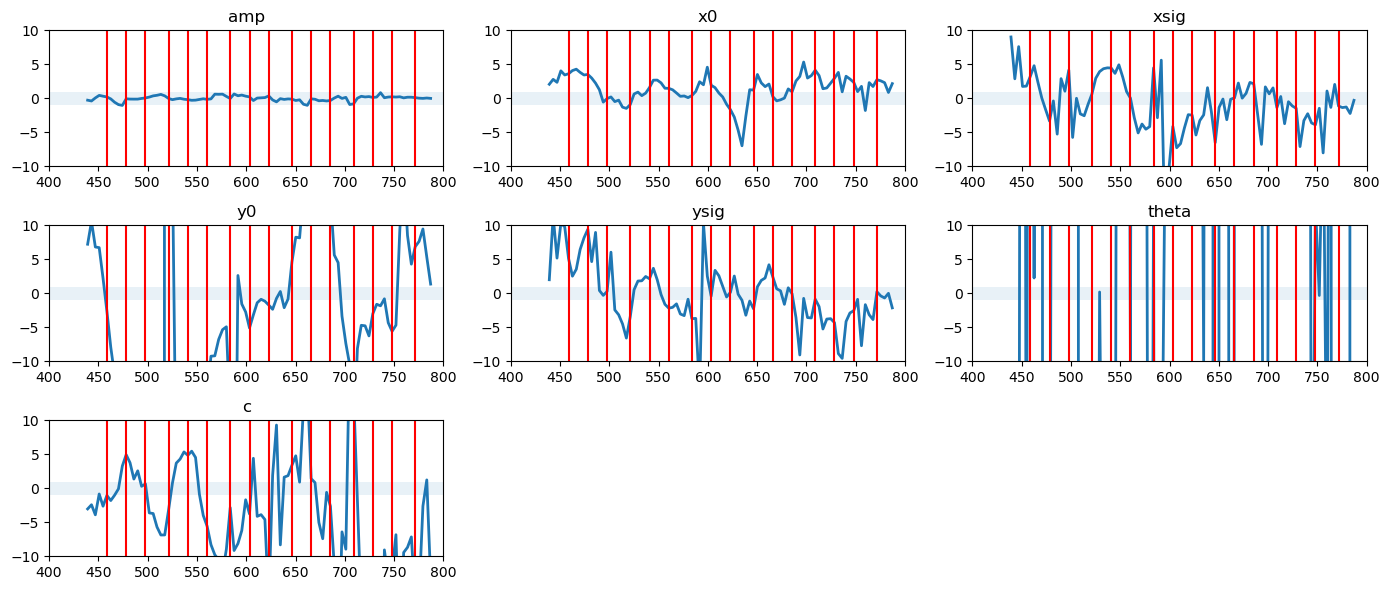

In [31]:
#see whether any big discrepancies correspond to freqs plotted above

param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,6))
counter = 1
for j, dishnum in enumerate([0]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(3,3,counter)
        try:
            ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
                    100*(fits_all_norm[1][:,dishnum,k]-fits_all_norm[2][:,dishnum,k])/fits_all_norm[1][:,dishnum,k], label = i, linewidth = 2)
        except: pass
#         ax.axvline(tempconcat.freq[500], color = 'red')
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        ax.set_xlim(400,800)
        ax.set_ylim(-10,10)
        ax.axhspan(-1,1,alpha = 0.1)
        
        
        for f in np.linspace(400,800,1024)[list(np.array(list(fitparams.keys()))[testargs])]:    
            ax.axvline(f, color = 'r')
        counter +=1

#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()


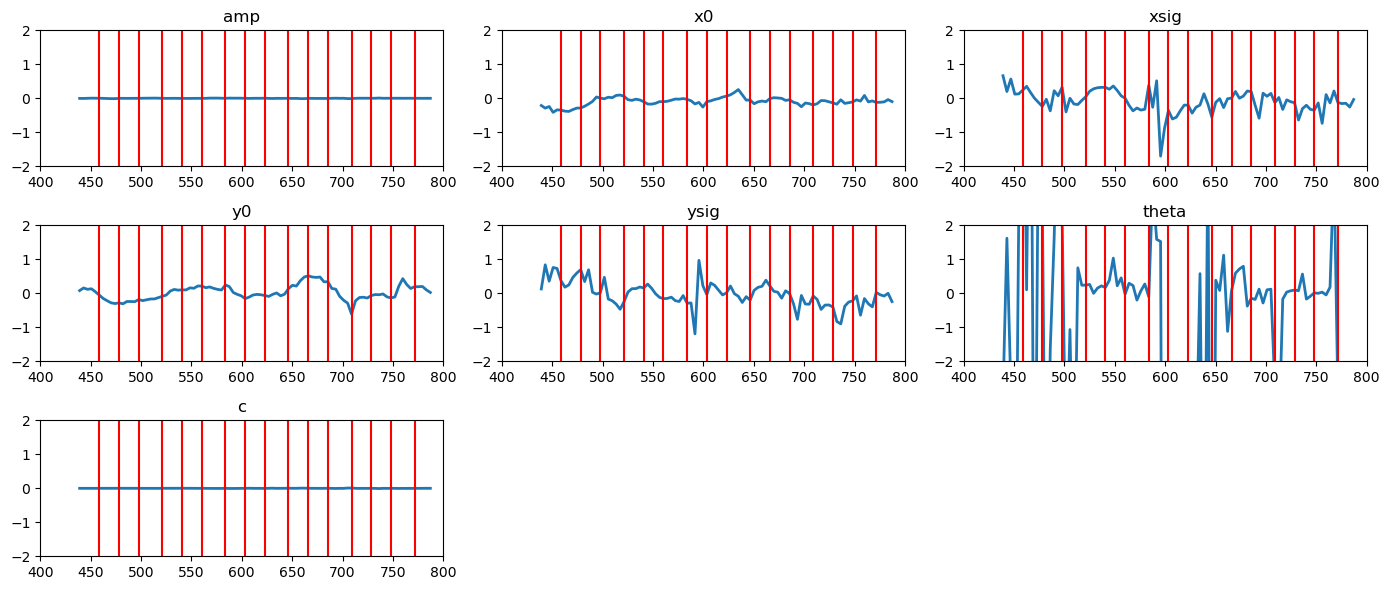

In [32]:
#see whether any big discrepancies correspond to freqs plotted above

param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,6))
counter = 1
for j, dishnum in enumerate([0]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(3,3,counter)
        try:
            ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
                    fits_all_norm[1][:,dishnum,k]-fits_all_norm[2][:,dishnum,k], label = i, linewidth = 2)
#             ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
#                     fits_all_norm[1][:,dishnum,k], label = i, linewidth = 2)
        except: pass
#         ax.axvline(tempconcat.freq[500], color = 'red')
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        ax.set_xlim(400,800)
        ax.set_ylim(-10,10)
#         ax.axhspan(-1,1,alpha = 0.1)
        
        
        for f in np.linspace(400,800,1024)[list(np.array(list(fitparams.keys()))[testargs])]:    
            ax.axvline(f, color = 'r')
        counter +=1
        ax.set_ylim(-2,2)

#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()


In [33]:
np.linspace(400,800,1024)[np.array(list(fitparams.keys()))[find]]

771.4565004887586

should make sure some of what im fitting isnt living in noise floor

In [34]:
indsuse = np.where((tempconcat.drone_xyz_LC_interp[:,0]<fits_all_norm[1][10,0,1]+) & (tempconcat.drone_xyz_LC_interp[:,0]>-50.0))[0]

tempconcat.t_index[indsuse]

SyntaxError: invalid syntax (1970557957.py, line 1)

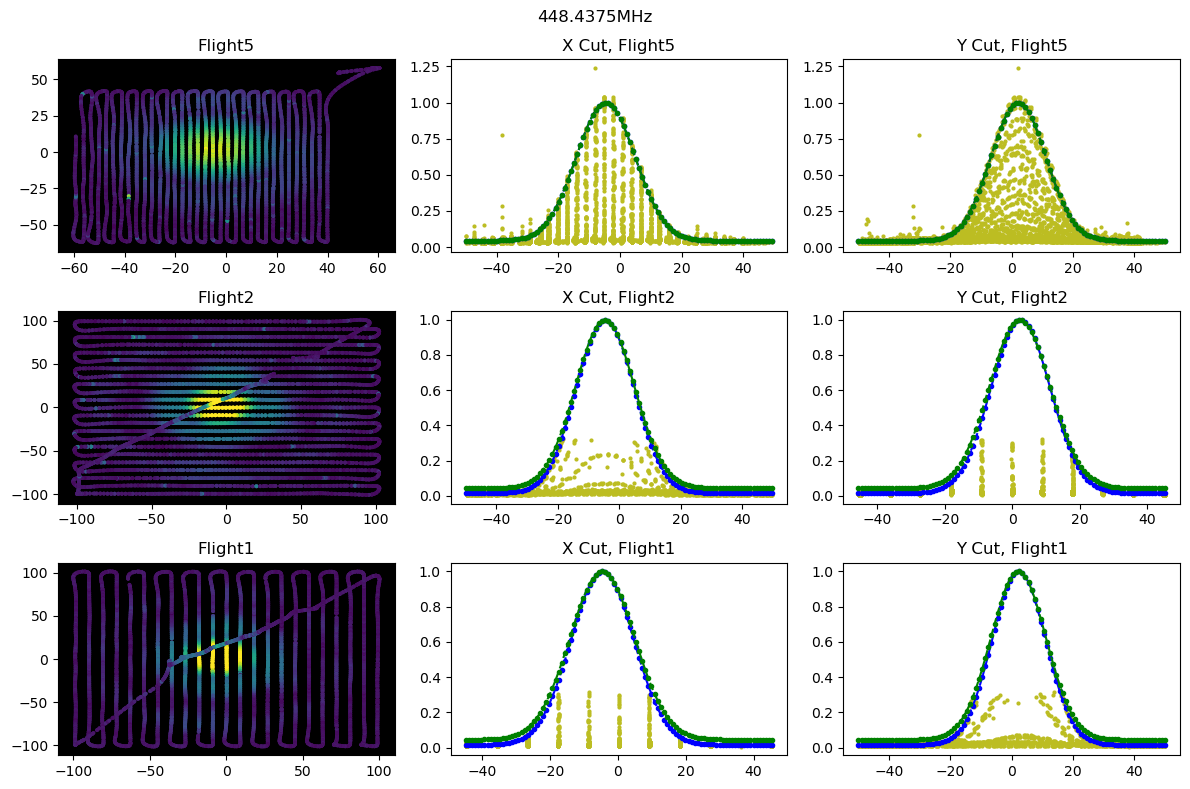

In [35]:
for find in [900]:
    fig=figure(figsize=(12,8))
    for counter, num in enumerate([5,2,1]):
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 5:
            Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


        ax=fig.add_subplot(3,3,3*(counter)+1)
        ax.set_title('Flight' + str(num))
        ax.set_facecolor('k')
        ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
                   c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)


        ax=fig.add_subplot(3,3,3*(counter)+2)

        ## PLOT 1
    #     ax=ax1
        ax.set_title('X Cut, Flight' + str(num)) 
        zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt5[3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')

        ax=fig.add_subplot(3,3,3*(counter)+3)

        ## PLOT 2
    #     ax=ax2
        ax.set_title('Y Cut, Flight' + str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,Gpopt5[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')
    suptitle(str(tempconcat.freq[find])+'MHz', fontsize = 12)
    tight_layout()
    show()



In [36]:
fits_all_norm[1][10,0,2]

7.157783366313226

In [37]:
for find in [900]:
    fig=figure(figsize=(12,8))
    for counter, num in enumerate([5,2,1]):
        if num in [1]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]
        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 1:
            Gpopt1=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data)
        if num == 2:
            Gpopt2=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 5:
            Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x




<Figure size 1200x800 with 0 Axes>

In [38]:
# how do we fit the two .... 
Gpopt1.grad

array([-5.62978268e-10, -2.38600293e-17, -1.97908052e-17,  3.30455784e-17,
       -8.13463187e-17,  9.50481706e-18, -1.51042592e-09])

In [39]:
# least_squares?

# thing to try: 

1. interpolate all onto same grid
2. adjust low power flight power by factor
3. take max at the point
3. fit gaussian

In [ ]:
res = 500

X,Y = np.meshgrixd(np.linspace(-100,100,500), np.linspace(-100,100,500))


num = 1
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z1 = griddata((x,y), z, (X,Y))


num = 2
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z2 = griddata((x,y), z, (X,Y))


num = 5
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
Z5 = griddata((x,y), z, (X,Y))


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


TypeError: Invalid shape (500, 500, 1024) for image data

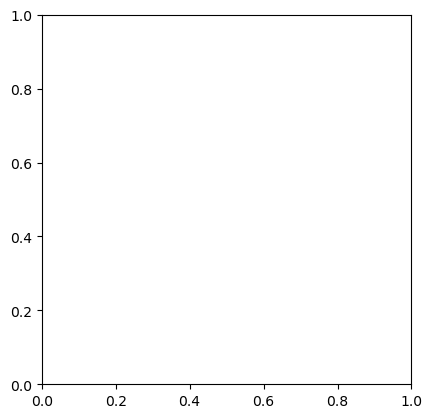

In [63]:
imshow(np.log10(Z1))
show()

In [ ]:
Z1[:,:,900].shape

In [60]:
# Z = np.nanmax([Z1,Z2,Z5], axis = 0)
# print(Z.shape)

In [46]:
freq = 900
Z = np.nanmax([Z1[:,:,freq],Z2[:,:,freq],Z5[:,:,freq]], axis = 0)
print(Z.shape)

(500, 500)


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN axis encountered
  


In [47]:
Z.shape

(500, 500)

In [48]:
mb_input_data = np.array([X.ravel(),Y.ravel(),Z.ravel()])

Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=Gpopt,args=mb_input_data).x            


ValueError: Residuals are not finite in the initial point.

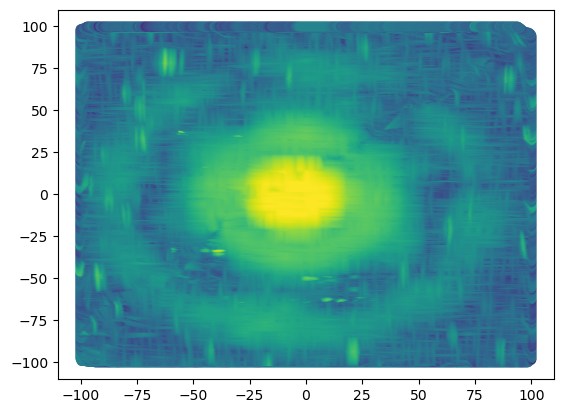

 ...]

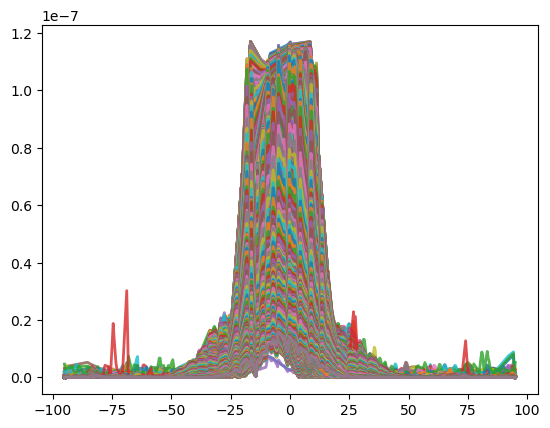

In [49]:
scatter(X.ravel(), Y.ravel(), c = np.log10(Z.ravel()))
show()


# plot(np.linspace(-95,95,100), Z1[:,50], linewidth = 2, alpha = 0.8)
plot(np.linspace(-95,95,res), Z1[int(res/2),:], linewidth = 2, alpha = 0.8)

# plot(np.linspace(-95,95,100), Z2[:,50], linewidth = 2, alpha = 0.8)
plot(np.linspace(-95,95,res), Z2[int(res/2),:], linewidth = 2, alpha = 0.8)



In [51]:
# Z = np.nanmax([Z1,Z2,Z5], axis = 0)
# Z.shape
# # plot(np.linspace(-95,95,res), Z[int(res/2),:], linewidth = 2, alpha = 0.8)

# z = np.mean(Z[:,:,900:920], axis = 2)

# imshow(np.log10(z))

In [53]:
# res = 1000

# X,Y = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))


# num = 1
# inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
# indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
# x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
# y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
# z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])
# Z1 = griddata((x,y), z, (X,Y))

In [54]:
# Z1[:,:,900].shape

z = np.mean(Z1[:,:,900:920], axis = 2)




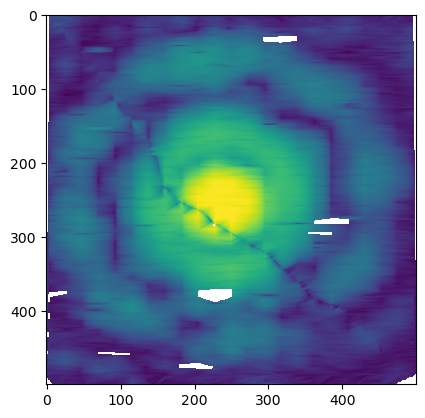

In [55]:
imshow(np.log10(z))

(500, 500)


/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: All-NaN axis encountered
  


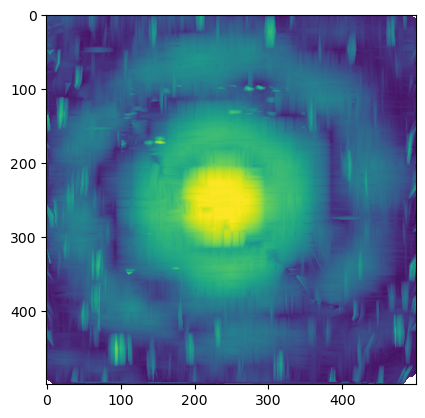

In [56]:
freq1 = 900
freq2 = 920
Z11 = np.mean(Z1[:,:,freq1:freq2], axis = 2)
Z22 = np.mean(Z2[:,:,freq1:freq2], axis = 2)
Z55 = np.mean(Z5[:,:,freq1:freq2], axis = 2)
Z = np.nanmax([Z11,Z22,Z55], axis = 0)

print(Z.shape)



imshow(np.log10(Z))

In [57]:
plot(np.linspace(-95,95,res), Z11[int(res/2),:], linewidth = 2, alpha = 0.8)
plot(np.linspace(-95,95,res), Z22[int(res/2),:], linewidth = 2, alpha = 0.8)
plot(np.linspace(-95,95,res), Z55[int(res/2),:], 'o', alpha = 0.8)
plot(np.linspace(-95,95,res), Z[int(res/2),:], linewidth = 2, alpha = 0.8)

show()
plot(np.linspace(-95,95,res), Z11[:,int(res/2)], linewidth = 2, alpha = 0.8)
plot(np.linspace(-95,95,res), Z22[:,int(res/2)], linewidth = 2, alpha = 0.8)
plot(np.linspace(-95,95,res), Z55[:,int(res/2)], 'o', alpha = 0.8)
plot(np.linspace(-95,95,res), Z[:,int(res/2)], linewidth = 2, alpha = 0.8)


IndexError: index 500 is out of bounds for axis 0 with size 500

In [ ]:
imshow(np.log10(Z55))

ValueError: x and y must have same first dimension, but have shapes (1000000,) and (250000,)

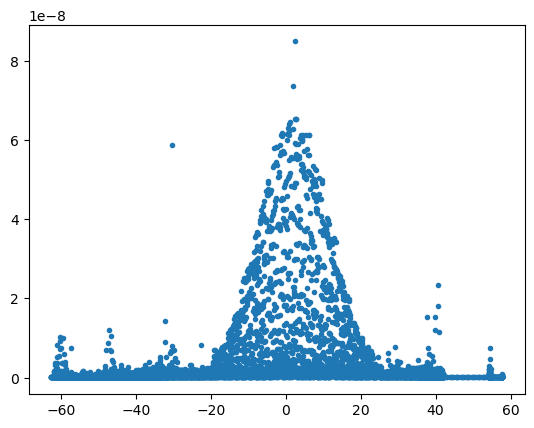

In [58]:
num = 5
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = np.abs(dict826[keys826[num]].V_bgsub[indsuse,:,1])

plot(y, np.mean(z[:,900:920], axis = 1), '.')
plot(Y.ravel(), Z55.ravel(), '.', markersize = 1)


looks like interpolation is making RFI seem more real..  

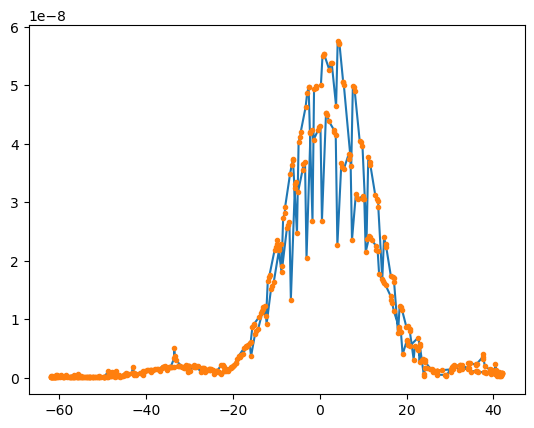

In [59]:
lb = 5500
ub = 6000

plot(y[lb:ub], np.mean(z[:,900:910][lb:ub], axis = 1))
plot(y[lb:ub], np.mean(z[:,900:910], axis = 1)[lb:ub], '.')
# plot(y[lb:ub], np.mean(z[:,900:901], axis = 1)[lb:ub], '.')
# plot(Y.ravel(), Z55.ravel(), '.', markersize = 1)


In [ ]:
# can Laura tackle this? 

In [ ]:
len(y)